In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull

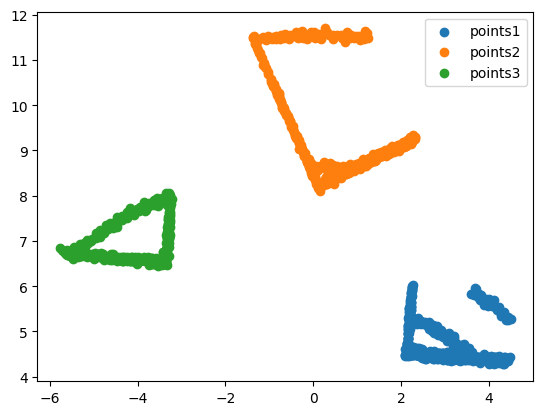

In [6]:
# Load the pickle files from data folder
points1 = np.load(f'data/points_1.pkl', allow_pickle=True)
points2 = np.load(f'data/points_2.pkl', allow_pickle=True)
points3 = np.load(f'data/points_3.pkl', allow_pickle=True)

# Plot the points
plt.figure()
plt.scatter(points1[:, 0], points1[:, 1], label='points1')
plt.scatter(points2[:, 0], points2[:, 1], label='points2')
plt.scatter(points3[:, 0], points3[:, 1], label='points3')
plt.legend()

In [50]:
def compute_convex_hull(points):
    """
    Compute the convex hull of a set of 2D points.
    
    Parameters:
        points (np.ndarray): A 2D array of shape (n, 2) representing the set of points.

    Returns:
        hull_points (np.ndarray): The coordinates of the points on the convex hull in counterclockwise order.
    """
    # Check if we have enough points to compute a convex hull
    if len(points) < 3:
        raise ValueError("Convex hull requires at least 3 points")

    # Compute the convex hull
    hull = ConvexHull(points)

    # Get the vertices that form the convex hull
    hull_points = points[hull.vertices]

    return hull_points

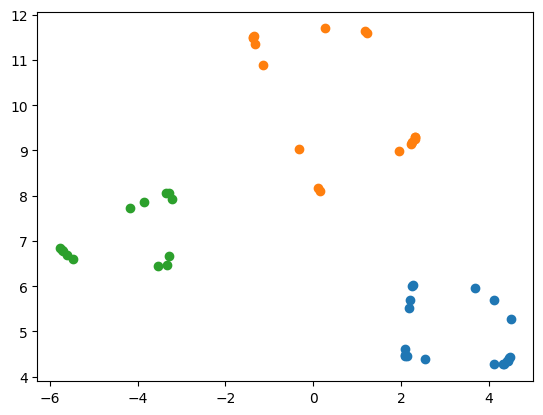

In [51]:
# Take the convex hull of the clusters and plot
hull_points1 = compute_convex_hull(points1)
hull_points2 = compute_convex_hull(points2)
hull_points3 = compute_convex_hull(points3)

plt.figure()
plt.scatter(hull_points1[:, 0], hull_points1[:, 1], label='hull_points1')
plt.scatter(hull_points2[:, 0], hull_points2[:, 1], label='hull_points2')
plt.scatter(hull_points3[:, 0], hull_points3[:, 1], label='hull_points3')

In [25]:
def detect_multiple_lines(points, num_lines=3):
    """Detect multiple lines in a cluster using RANSAC."""
    lines = []
    remaining_points = points.copy()

    for _ in range(num_lines):
        if len(remaining_points) < 2:
            break

        # Perform RANSAC in 2D (fit line y = ax + b)
        X = remaining_points[:, 0].reshape(-1, 1)  # Extract X coordinates
        Y = remaining_points[:, 1]  # Extract Y coordinates

        ransac = RANSACRegressor()
        ransac.fit(X, Y)

        # Get the line parameters: slope (a) and intercept (b)
        a = ransac.estimator_.coef_[0]
        b = ransac.estimator_.intercept_

        # Define the line segment endpoints for visualization
        x_min, x_max = np.min(X), np.max(X)
        y_min, y_max = a * x_min + b, a * x_max + b
        lines.append(((x_min, y_min), (x_max, y_max)))

        # Get the inliers (points close to the line)
        inlier_mask = ransac.inlier_mask_
        inlier_points = remaining_points[inlier_mask]

        # Plot the inliers, outliers and the line
        plt.figure()
        plt.scatter(inlier_points[:, 0], inlier_points[:, 1], marker='x', label='inliers')
        plt.scatter(remaining_points[~inlier_mask][:, 0], remaining_points[~inlier_mask][:, 1], marker='x', label='outliers')
        plt.plot([x_min, x_max], [y_min, y_max], label='line', color='red')
        plt.legend()
        
        # Remove inlier points from the remaining points for the next iteration
        remaining_points = remaining_points[~inlier_mask]

    return lines

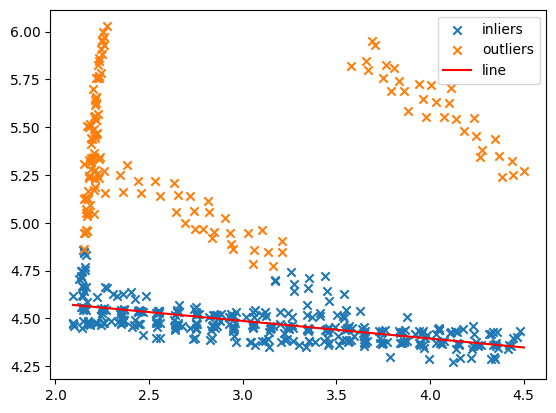

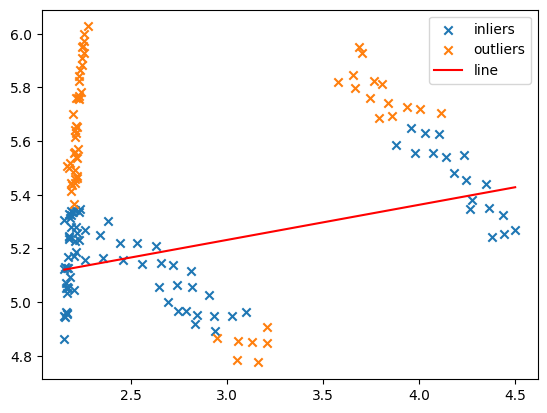

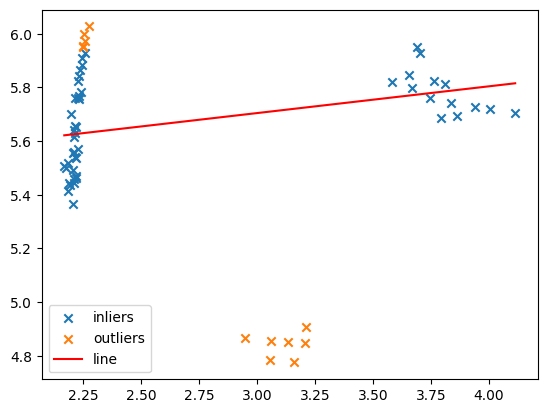

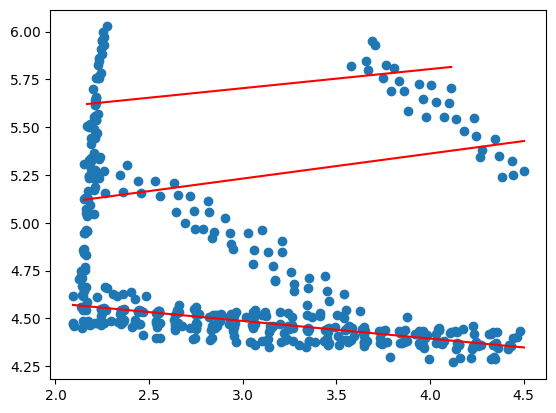

In [26]:
# Detect and plot lines for points1
lines1 = detect_multiple_lines(points1)
plt.figure()
plt.scatter(points1[:, 0], points1[:, 1], label='points1')
for line in lines1:
    plt.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], 'r-')

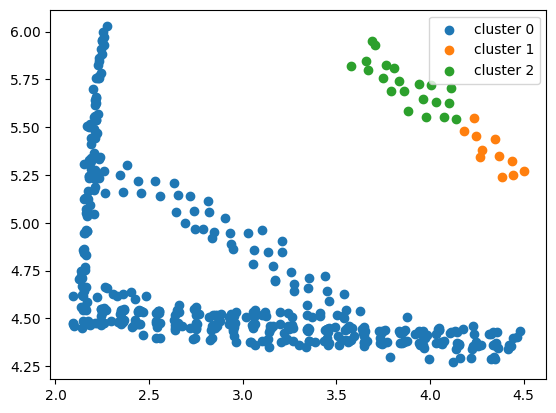

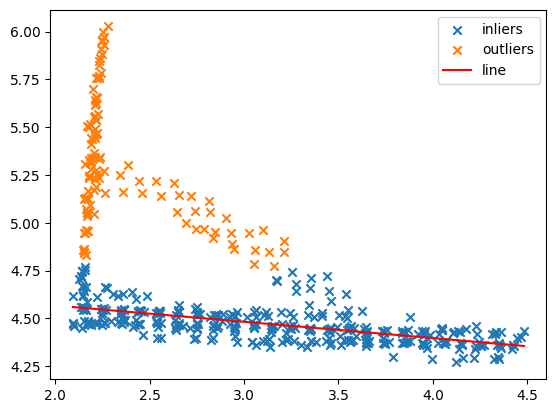

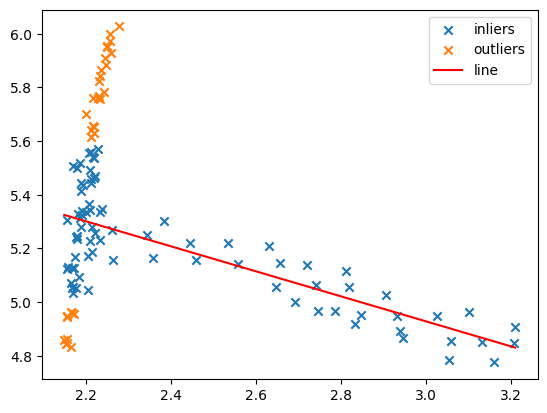

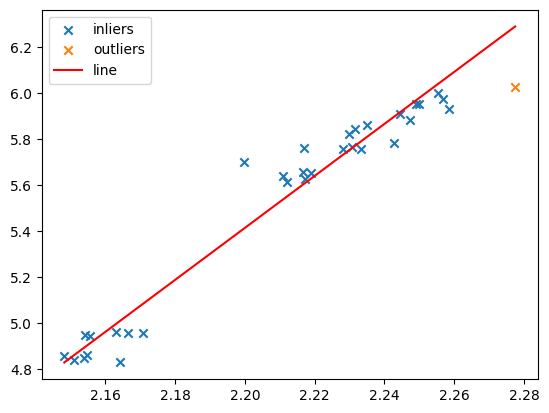

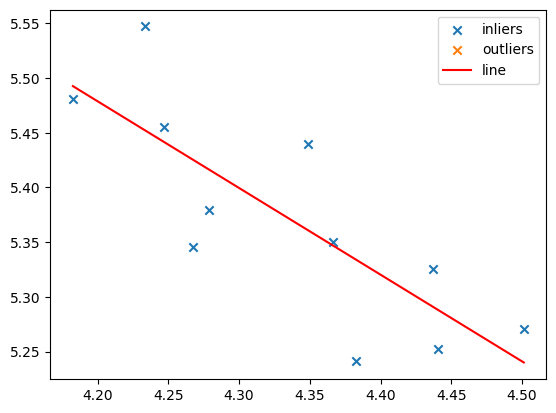

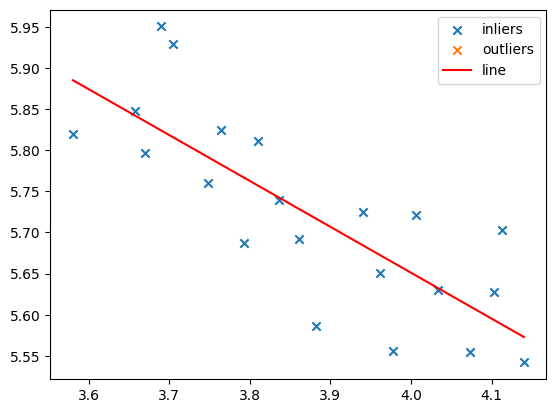

In [43]:
# Cluster points
dbscan = DBSCAN(eps=0.12).fit(points1)
labels = dbscan.labels_

# Plot the clusters
plt.figure()
for label in np.unique(labels):
    cluster = points1[labels == label]
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'cluster {label}')
plt.legend()

# Apply ransec to each cluster
for label in np.unique(labels):
    cluster = points1[labels == label]
    detect_multiple_lines(cluster)

In [46]:
def detect_constrained_lines(points, num_lines=2, slope_tolerance=0.1):
    """Detect lines with constraints to fit perpendicular lines."""
    remaining_points = points.copy()
    lines = []

    # First, fit the first line using RANSAC
    X = remaining_points[:, 0].reshape(-1, 1)  # X-coordinates
    Y = remaining_points[:, 1]  # Y-coordinates
    ransac = RANSACRegressor()
    ransac.fit(X, Y)

    # Extract the first line parameters
    a1 = ransac.estimator_.coef_[0]  # Slope of the first line
    b1 = ransac.estimator_.intercept_

    # Calculate endpoints for visualization
    x_min, x_max = np.min(X), np.max(X)
    y_min, y_max = a1 * x_min + b1, a1 * x_max + b1
    lines.append(((x_min, y_min), (x_max, y_max)))

    # Remove inliers of the first line
    inlier_mask = ransac.inlier_mask_
    remaining_points = remaining_points[~inlier_mask]

    # For subsequent lines, enforce slope constraints
    for _ in range(num_lines - 1):
        if len(remaining_points) < 2:
            break

        # Compute the slope range for perpendicular line
        constrained_slope = -1 / a1  # Slope of perpendicular line
        slope_range = (constrained_slope - slope_tolerance, constrained_slope + slope_tolerance)

        # Filter points based on slope to ensure we fit the perpendicular line
        new_ransac = RANSACRegressor()
        X_remain = remaining_points[:, 0].reshape(-1, 1)
        Y_remain = remaining_points[:, 1]

        # Custom fitting process with a slope constraint
        best_slope = None
        best_intercept = None
        best_inliers = None
        min_error = float('inf')

        # Try different fits until we find one within the constrained slope range
        for _ in range(100):  # Iterate to find the best line within constraints
            new_ransac.fit(X_remain, Y_remain)
            a2 = new_ransac.estimator_.coef_[0]
            b2 = new_ransac.estimator_.intercept_

            # Check if the slope falls within the desired range
            if slope_range[0] <= a2 <= slope_range[1]:
                # Calculate error (sum of distances between inliers and line)
                inlier_mask = new_ransac.inlier_mask_
                residual_error = np.sum(np.abs(Y_remain[inlier_mask] - (a2 * X_remain[inlier_mask].ravel() + b2)))
                if residual_error < min_error:
                    best_slope = a2
                    best_intercept = b2
                    best_inliers = inlier_mask
                    min_error = residual_error

        if best_slope is None:
            print("No valid perpendicular line found.")
            break

        # Append the best line
        x_min_remain, x_max_remain = np.min(X_remain), np.max(X_remain)
        y_min_remain = best_slope * x_min_remain + best_intercept
        y_max_remain = best_slope * x_max_remain + best_intercept
        lines.append(((x_min_remain, y_min_remain), (x_max_remain, y_max_remain)))

        # Remove inliers of the new line
        remaining_points = remaining_points[~best_inliers]

    return lines

In [47]:
# detect constrained lines
lines1 = detect_constrained_lines(points1)

No valid perpendicular line found.
